# Computational Mechanics Project #02 - Create specifications for a projectile robot

On the first day of class, we threw $2"\times~2"$ dampened paper (spitballs) at a target on the whiteboard. Now, we are going to analyze the accuracy of the class with some cool Python tools and design a robot that has the same accuracy and precision as the class, but we will have the robot move farther away from the target and use a simpler projectile i.e. a tennis ball so we don't need to worry about knuckle-ball physics. 

The goal of this project is to determine the precision of necessary components for a robot that can reproduce the class throwing distibution. We have generated pseudo random numbers using `numpy.random`, but the class target practice is an example of truly random distributions. If we repeated the exercise, there is a vanishingly small probability that we would hit the same points on the target, and there are no deterministic models that could take into account all of the factors that affected each hit on the board. 

<img src="../images/robot_design.png" style="height: 250px;"/>

Now, we ask ourselves some questions:

1. How do we quantify the class accuracy and precision?

2. If we design a robot, what design components can we control?

3. How can we relate the controlled components to the class accuracy, and specify the component precision?

The first question, we have some experience from our work in [02_Seeing_Stats](../notebooks/02_Seeing_Stats.ipynb). We can define the mean, standard deviation, measure the first, second, and third quartiles,  etc. 

The second question is a physical question. We cannot control the placement of the robot or the target those are chosen for us. We cannot control temperature, mechanical vibrations, etc. We *can* control the desired initial velocity. The initial velocity will have some speed and direction, and both will be subject to random noise. Once the speed and direction are set, the location on the target is determined by kinematic equations for an object in freefall, as such

$x_{impact} = \frac{v_x}{v_y}d + x(0)~~~~~~~~~~~~~~~~~~~~(1.a)$

$z_{impact} = d\left(\frac{v_z(0)}{v_y}-\frac{g}{2v_y^2}d\right)+ z(0)~~~~~(1.b)$.

Where the location of impact is at a $y$-distance of $d$ at a point on the target with coordinates $(x_{impact},~z_{impact})$, and the initial velocity is $\bar{v}=v_x\hat{i}+v_y\hat{j}+v_z(0)\hat{k}$, the object is released at an initial location $\bar{r}(0)=x(0)\hat{i}+0\hat{j}+z(0)\hat{k}$, and the only acceleration is due to gravity, $\bar{a}=-g\hat{k}$. Equation (1) becomes much easier to  evaluate if we assume that $v_x=0$, resulting in an evalution of the accuracy of the height of the impact, $z_{impact}$, as such

$x_{impact} = x(0)~~~~~~~~~~~~~~~~~~~~(2.a)$

$z_{impact} = \frac{d}{\cos{\theta}}\left(\sin{\theta}-\frac{g}{2v_0^2\cos{\theta}}d\right)+ z(0)~~~~~(2.b)$.

Where $\theta$ is the angle of the initial velocity and $v_0$ is the initial speed. Equation (2) restricts the analysis to height accuracy. You can incorporate the 2D impact analysis if you finish the 1D analysis.

The third question, is how we can relate equation (2) to the measured points of impact? For this, we can use Monte Carlo methods *(There are other methods, but Monte Carlo is one of the most straight-forward)*. Our Monte Carlo approach is as such, if we have a desired initial speed, $v_0$, and desired angle, $\theta$, we can propagate the uncertainty of our actual speeds and angles into the $z_{impact}$ locations. Then, we can choose distributions in speed and angles that match the distributions in $z_{impact}$ locations. Here are the steps:

1. Generate random $\theta_i$ and $v_{0~i}$ variables

2. Plug into eqn 2 for random $z_{impact~i}$ locations

3. Compare to our measured $z_{impact}$ location statistics

4. Repeat 1-3 until the predicted uncertainty matches the desired uncertainty, we can use a number of comparison metrics:
    
    - standard deviation
    
    - first, second, and third quartiles
    
    - visually, with box plots and histograms

# Project Deliverables

1. Statistical analysis of class accuracy and precision (x- and z-locations) data is in the csv file  [../data/target_data.csv](../data/target_data.csv) _Note: if you want to see how I turned the images into data check out the jupyter notebook [process_target_practice](./process_target_practice.ipynb)

2. A Monte Carlo model to generate impact heights based upon uncertainty in $\theta_0$ and $v_0$. 

3. The precision required to recreate the class accuracy and precision with a robot. 
**You must show some validation of your work**

4. [BONUS] Repeat 2-3 taking into account the variation in $x_{impact}$ due to misalignment. 

Given constants and constraints:

- $d=$3 m, distance to target

- $g=$9.81 m/s$^2$, acceleration due to gravity

- $z(0)=$0.3 m,  the initial height is 0.3 m above the bull's eye

- 4 m/s$<v_0<$12 m/s, the initial velocity is always higher than 9 mph and less than 27 mph

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Import rcParams to set font styles
from matplotlib import rcParams

#Set font style and size 
rcParams['font.family'] = 'sans'
rcParams['font.size'] = 18
rcParams['lines.linewidth'] = 3

In [2]:
data = pd.read_csv('../data/target_data.csv')
xloc = data[' x position (m)'].values
yloc = data[' y position (m)'].values

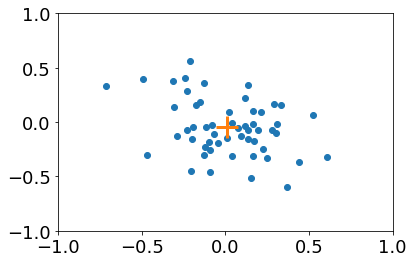

In [3]:
mu_x = xloc.mean()
mu_y = yloc.mean()
plt.scatter(xloc,yloc,label='hit locations')
plt.scatter(mu_x,mu_y,marker='+',s=500,label='avg location')
plt.axis([-1,1,-1,1]);

Text(0.5, 1.0, 'Box-plots for x and y hit locations')

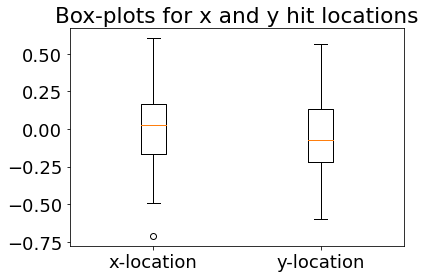

In [4]:
plt.boxplot([xloc,yloc],labels=['x-location','y-location'])
plt.title('Box-plots for x and y hit locations')

the class location first quartile is	 x=-16.9 cm, y=-21.8 cm
the class location second quartile is	 x=2.8 cm, y=-7.1 cm
the class location third quartile is	 x=16.7 cm, y=13.2 cm
min and max y-location = -59.7 cm and 56.4 cm


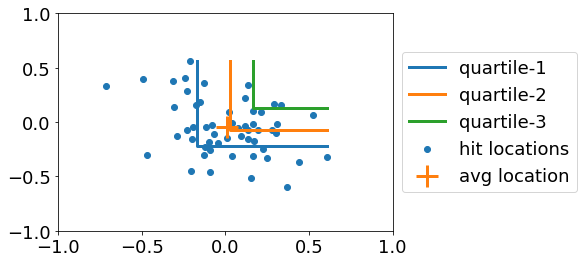

In [5]:
xq = np.percentile(xloc, q=[25,50,75])

yq = np.percentile(yloc, q=[25,50,75])

print('the class location first quartile is\t x={:.1f} cm, y={:.1f} cm'.format(xq[0]*100,yq[0]*100))
print('the class location second quartile is\t x={:.1f} cm, y={:.1f} cm'.format(xq[1]*100,yq[1]*100))
print('the class location third quartile is\t x={:.1f} cm, y={:.1f} cm'.format(xq[2]*100,yq[2]*100))
print('min and max y-location = {:.1f} cm and {:.1f} cm'.format(yloc.min()*100,yloc.max()*100))
plt.scatter(xloc,yloc,label='hit locations')
plt.scatter(mu_x,mu_y,marker='+',s=500,label='avg location')


for i in range(0,3):
    xline = np.array([xq[i],xq[i],np.max(xloc)])
    yline = np.array([np.max(yloc),yq[i],yq[i]])
    plt.plot(xline,yline,label='quartile-{}'.format(i+1))

plt.axis([-1,1,-1,1]);
plt.legend(bbox_to_anchor=(1,0.5),loc='center left');

## Note about quartiles

The quartiles show you the dividing lines for when data points are above a given line. In the above plot, 50\% of the data is in the box bounded by quartile-1 and quartile-2, but if you look at any given quartile, it is dividing the data into a less-than more than line.

$z_{impact} = \frac{d}{\cos{\theta}}\left(\sin{\theta}-\frac{g}{2v_0^2\cos{\theta}}d\right)+ z(0)~~~~~(2.b)$.

Given constants and constraints:

- $d=$3 m, distance to target

- $g=$9.81 m/s$^2$, acceleration due to gravity

- $z(0)=$0.3 m,  the initial height is 0.3 m above the bull's eye

- 4 m/s$<v_0<$12 m/s, the initial velocity is always higher than 9 mph and less than 27 mph

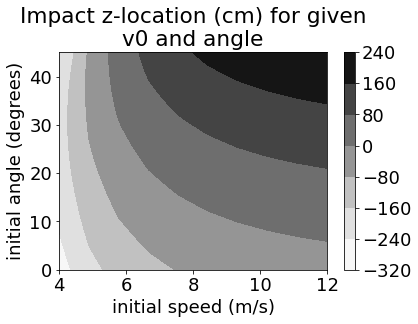

In [6]:
from matplotlib import cm
def z_impact(v0,a,d=3,g=9.81,z0=0.3):
    z = d/np.cos(a)*(np.sin(a)-g/2/v0**2/np.cos(a)*d)+z0-z0
    return z
v=np.linspace(4,12,10)
a=np.linspace(0,np.pi/4)
V,A = np.meshgrid(v,a)
Z = z_impact(V,A)
plt.contourf(V,A*180/np.pi,Z*100,cmap=cm.Greys)
plt.xlabel('initial speed (m/s)')
plt.ylabel('initial angle (degrees)')
plt.title('Impact z-location (cm) for given\nv0 and angle')
plt.colorbar();

The hit location in along the y axis going from 4-12 m/s can be -320-240 cm, but our locations min-max are -60 cm - 56 cm, so we can only use a narrow region of the given range of speeds. In this example I'll assume the average speed of the thrown object was

* mean(v) == 8 m/s

this means the average angle has to be

* mean($\theta$)  $\approx 13.69^o$

The variance in the angles and speeds should reflect the variance in the measured locations, this part is a little trial-and-error, but the main deliverable is to create a Monte Carlo model that simulates hit locations based upon the random angles and random speeds. 

Playing around with `range_a` and `range_v` will result in the boxplots and histograms of impact heights being visually similar.

In [7]:
print(z_impact(8,13.69*np.pi/180))
print(len(yloc))

7.325419624143459e-05
54


In [8]:
def montecarlo_z(range_v=2.5, range_a=15*np.pi/180, mean_v = 8, mean_a = 13.69*np.pi/180,number_hits=54):
    ra = np.random.rand(number_hits)
    rv = np.random.rand(number_hits)
    a = ra*range_a + mean_a-np.mean(ra*range_a)
    v = rv*range_v + mean_v-np.mean(rv*range_v)
    z_hits = z_impact(v,a)
    return z_hits

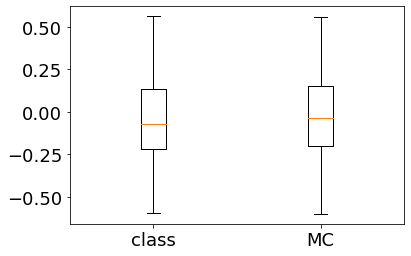

In [9]:
zMC = montecarlo_z(number_hits=1000)
plt.boxplot([yloc,zMC],labels=['class','MC']);

AttributeError: 'Polygon' object has no property 'normed'

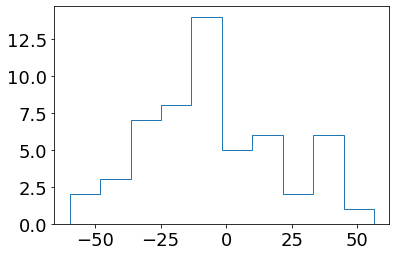

In [10]:
plt.hist(yloc*100,normed=True,histtype='step',label='class',linewidth=3)
plt.hist(zMC*100,normed=True,histtype='step',label='Monte Carlo',linewidth=3)
plt.xlabel('y location impact (cm)')
plt.legend();